In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'figure.figsize': (10, 3),
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'serif'],
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'axes.grid': True,
    'lines.linewidth': 2,
    'lines.markersize': 7,
    'axes.facecolor': '#f5f5f5',
    'figure.facecolor': '#f5f5f5',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.loc': 'best',
})


## Simulating Vasicek Short Rates

In [3]:
def simulate_vasicek_short_rates_euler(r0, kappa, theta, sigma, t, dt, seed=None):
    """
    Simulates the Vasicek short rates model using the 
    Euler-Maruyama discretization. 
    
    Parameters:
    r0 (float): Initial (current) short rate.
    kappa (float): Speed of mean reversion.
    theta (float): Long-term mean level of the short rate.
    sigma (float): Annualized volatility of the short rate process.
    t (float): Number of years to simulate.
    dt (float): Time step size.
    
    Returns:
    times (np.ndarray): Time steps.
    rates (np.ndarray): Simulated short rates.
    """

    np.random.seed(seed)
    
    nd = int(t / dt)

    times = np.linspace(0, t, nd)

    rates = np.zeros(nd)
    rates[0] = r0

    diffusion = sigma * np.random.normal(0, np.sqrt(dt), nd-1)

    for t in range(1, nd):
        dr = kappa * (theta - rates[t-1]) * dt + diffusion[t-1]
        rates[t] = rates[t-1] + dr
        
    return times, rates


In [4]:
def simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, seed=None):
    """
    Simulates the Vasicek short rates model using the 
    Doob (analytical solution)
    
    Parameters:
    r0 (float): Initial (current) short rate.
    kappa (float): Speed of mean reversion.
    theta (float): Long-term mean level of the short rate.
    sigma (float): Annualized volatility of the short rate process.
    t (float): Number of years to simulate.
    dt (float): Time step size.
    
    Returns:
    times (np.ndarray): Time steps.
    rates (np.ndarray): Simulated short rates.
    """

    np.random.seed(seed)

    nd = int(t / dt)

    times = np.linspace(0, t, nd)

    rates = np.zeros(nd)
    rates[0] = r0

    exp_kappa_dt = np.exp(-kappa * dt)
    diffusion_std = sigma * np.sqrt((1 - np.exp(-2 * kappa * dt)) / (2 * kappa))
    for t in range(1, nd):
        exp_rate = (theta * (1 - exp_kappa_dt) + rates[t-1] * exp_kappa_dt)
        rates[t] = np.random.normal(exp_rate, diffusion_std)
    
    return times, rates


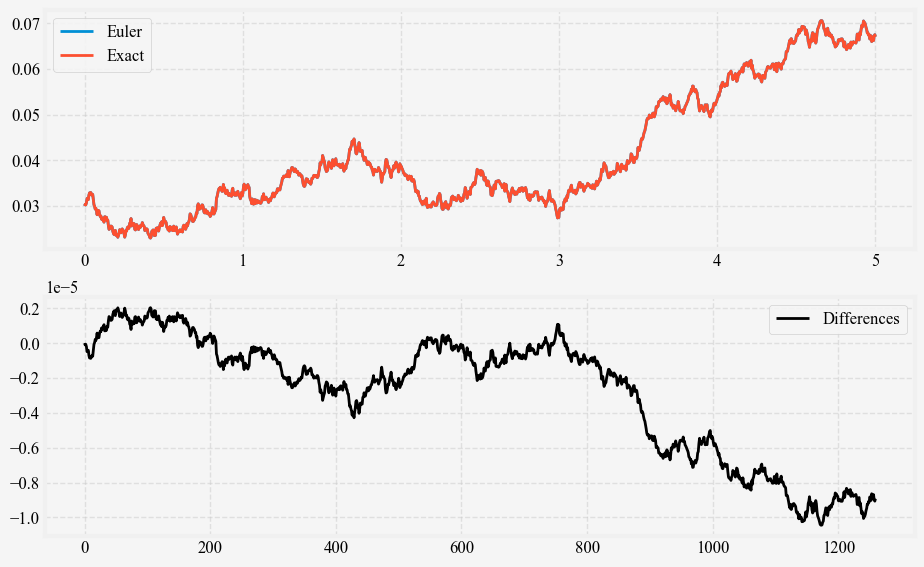

In [220]:
# Vasicek simulation parameters
r0 = 0.03
kappa = 0.15
theta = 0.05
sigma = 0.01
dt = 1/252  # Daily time steps
t = 5  # Total time in years
seed = 42

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6.5))

# Simulate using Euler discretization
rates_euler = simulate_vasicek_short_rates_euler(r0, kappa, theta, sigma, t, dt, seed)
axes[0].plot(*rates_euler, label='Euler')

# Simulate using exact discretization
rates_exact = simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, seed)
axes[0].plot(*rates_exact, label='Exact')

axes[0].legend()

axes[1].plot(rates_exact[1] - rates_euler[1], color='k', label='Differences')
axes[1].legend()

plt.show()

rates = rates_exact[1]  # Assuming market observed short rates are the simulated exact rates


## OU Parameters Estimation using MLE

In [246]:
def vasicek_quasi_log_likelihood(params, rates, dt):
    kappa, theta, sigma = params
    
    exp_r = rates[:-1] + kappa * (theta - rates[:-1]) * dt
    var_r = sigma**2 * dt
    
    logL = np.sum(
        -0.5 * (
            np.log(2 * np.pi * var_r) + 
            (rates[1:] - exp_r)**2 / var_r
        )
    )
    
    return -logL

def calibrate_vasicek_qmle(rates, dt):
    initial_params = [np.random.uniform(0, 1), np.mean(rates), np.std(np.diff(rates)) * np.sqrt(1/dt)]
    bounds = [(1e-8, None), (None, None), (1e-8, None)]
    
    result = minimize(
        vasicek_quasi_log_likelihood, initial_params, 
        args=(rates, dt), bounds=bounds, method='Powell'
    )
    
    kappa, theta, sigma = result.x
    return kappa, theta, sigma


def vasicek_log_likelihood(params, rates, dt):
    kappa, theta, sigma = params
    
    exp_r = theta * (1 - np.exp(-kappa * dt)) + rates[:-1] * np.exp(-kappa * dt)
    var_r = sigma**2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
    
    logL = np.sum(
        -0.5 * (
            np.log(2 * np.pi * var_r) + 
            (rates[1:] - exp_r)**2 / var_r
        )
    )
    
    return -logL


def calibrate_vasicek_mle(rates, dt):
    initial_params = [np.random.uniform(0, 1), np.mean(rates), np.std(np.diff(rates)) * np.sqrt(1/dt)]
    bounds = [(1e-8, None), (None, None), (1e-8, None)]
    
    result = minimize(
        vasicek_log_likelihood, initial_params, 
        args=(rates, dt), bounds=bounds, method='Powell'
    )
    
    kappa, theta, sigma = result.x
    return kappa, theta, sigma



In [247]:
# MLE Parameter Estimation
kappa_mle, theta_mle, sigma_mle = calibrate_vasicek_mle(rates, dt)
kappa_qmle, theta_qmle, sigma_qmle = calibrate_vasicek_qmle(rates, dt)
print(f'MLE calibrated parameters: kappa={kappa_mle}, theta={theta_mle}, sigma={sigma_mle}')
print(f'QMLE calibrated parameters: kappa={kappa_qmle}, theta={theta_qmle}, sigma={sigma_qmle}')
print(f"Ground truth: kappa={kappa}, theta={theta}, sigma={sigma}")

MLE calibrated parameters: kappa=0.5019017476398434, theta=0.004135277959598869, sigma=0.009873533948884532
QMLE calibrated parameters: kappa=0.5013474865259051, theta=0.004134240096398378, sigma=0.00986532799244667
Ground truth: kappa=0.15, theta=0.05, sigma=0.01


In [248]:
kappa_ests_mle = []
theta_ests_mle = []
sigma_ests_mle = []

kappa_ests_qmle = []
theta_ests_qmle = []
sigma_ests_qmle = []

num_run = 5000
np.random.seed(42)
random_seeds = np.random.randint(0, 100000, num_run)
for i in range(num_run):
    if i % 500 == 0:
        print(i)
    _, rates =  simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, random_seeds[i])
    kappa_est, theta_est, sigma_est = calibrate_vasicek_mle(rates, dt)
    kappa_qest, theta_qest, sigma_qest = calibrate_vasicek_qmle(rates, dt)
    kappa_ests_mle.append(kappa_est)
    theta_ests_mle.append(theta_est)
    sigma_ests_mle.append(sigma_est)
    kappa_ests_qmle.append(kappa_qest)
    theta_ests_qmle.append(theta_qest)
    sigma_ests_qmle.append(sigma_qest)


0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [249]:

kappa_ests_mle_mean = np.mean(kappa_ests_mle, axis=0)
theta_ests_mle_mean = np.mean(theta_ests_mle, axis=0)
sigma_ests_mle_mean = np.mean(sigma_ests_mle, axis=0)

kappa_ests_mle_median = np.median(kappa_ests_mle, axis=0)
theta_ests_mle_median = np.median(theta_ests_mle, axis=0)
sigma_ests_mle_median = np.median(sigma_ests_mle, axis=0)

kappa_ests_mle_std = np.std(kappa_ests_mle, axis=0)
theta_ests_mle_std = np.std(theta_ests_mle, axis=0)
sigma_ests_mle_std = np.std(sigma_ests_mle, axis=0)

kappa_ests_qmle_mean = np.mean(kappa_ests_qmle, axis=0)
theta_ests_qmle_mean = np.mean(theta_ests_qmle, axis=0)
sigma_ests_qmle_mean = np.mean(sigma_ests_qmle, axis=0)

kappa_ests_qmle_median = np.median(kappa_ests_qmle, axis=0)
theta_ests_qmle_median = np.median(theta_ests_qmle, axis=0)
sigma_ests_qmle_median = np.median(sigma_ests_qmle, axis=0)

kappa_ests_qmle_std = np.std(kappa_ests_qmle, axis=0)
theta_ests_qmle_std = np.std(theta_ests_qmle, axis=0)
sigma_ests_qmle_std = np.std(sigma_ests_qmle, axis=0)



Text(0.5, 1.0, 'Histogram of MLE Estimated $\\kappa$')

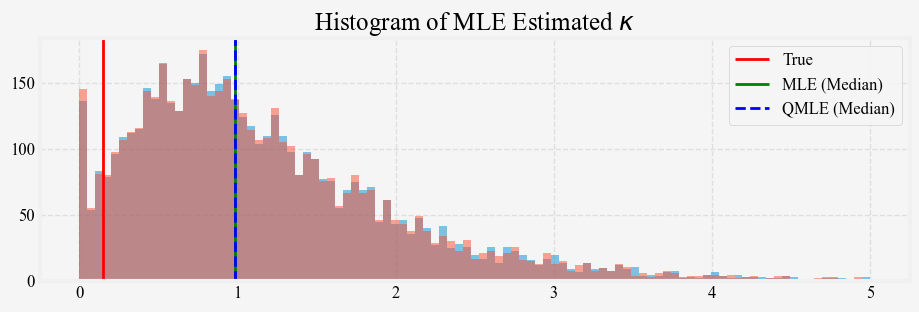

In [255]:
import scipy
bins = np.linspace(0, 5, 100)
plt.hist(kappa_ests_mle, bins=bins, alpha=0.5)
plt.hist(kappa_ests_qmle, bins=bins, alpha=0.5)
plt.axvline(kappa, color='r')
plt.axvline(kappa_ests_mle_median, color='g')
plt.axvline(kappa_ests_qmle_median, color='b', linestyle='--')
plt.legend(['True', 'MLE (Median)', 'QMLE (Median)'])
plt.title('Histogram of MLE Estimated $\kappa$')


Text(0.5, 1.0, 'Histogram of MLE Estimated $\\theta$')

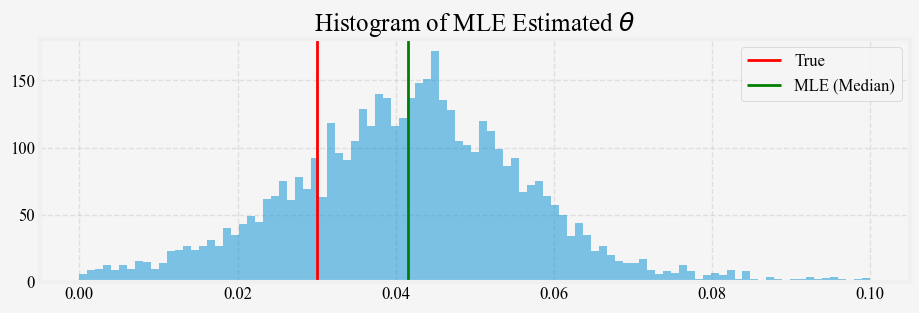

In [53]:
import scipy
bins = np.linspace(0, 0.1, 100)
plt.hist(theta_ests_mle, bins=bins, alpha=0.5)
plt.axvline(theta, color='r')
plt.axvline(theta_ests_mle_median, color='g')
plt.legend(['True', 'MLE (Median)'])
plt.title('Histogram of MLE Estimated $\\theta$')


Text(0.5, 1.0, 'Histogram of MLE Estimated $\\sigma$')

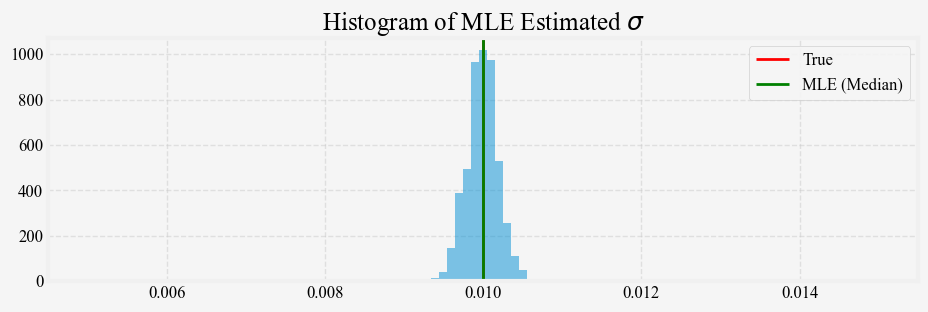

In [54]:
import scipy
bins = np.linspace(0.005, 0.0150, 100)
plt.hist(sigma_ests_mle, bins=bins, alpha=0.5)
plt.axvline(sigma, color='r')
plt.axvline(sigma_ests_mle_median, color='g')
plt.legend(['True', 'MLE (Median)'])
plt.title('Histogram of MLE Estimated $\sigma$')

## OU Parameters Estimation using Particle Filtering

In [280]:
import numpy as np
from numba import njit, prange

@njit
def ou_transition(x, kappa, theta, sigma, dt):
    mean = x * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
    var = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt))
    return np.random.normal(mean, np.sqrt(var))

@njit
def compute_likelihood(r_prev, r_curr, kappa, theta, sigma, dt):
    mean = r_prev * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
    var = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt))
    return np.exp(-0.5 * ((r_curr - mean)**2 / var)) / np.sqrt(2 * np.pi * var)

@njit
def weighted_resample(particles, weights):
    N = len(weights)
    indices = np.zeros(N, dtype=np.int64)
    C = np.cumsum(weights)
    u0 = np.random.random() / N
    j = 0
    for i in range(N):
        u = u0 + i / N
        while u > C[j]:
            j += 1
        indices[i] = j
    return particles[indices]

@njit
def estimate(particles, weights):
    return np.sum(particles * weights[:, np.newaxis], axis=0)

@njit
def weighted_cov(X, w):
    mean = np.sum(X * w[:, np.newaxis], axis=0)
    Xm = X - mean
    cov = np.dot(Xm.T, Xm * w[:, np.newaxis])
    return cov

@njit
def adaptive_kernel(particles, weights):
    cov = weighted_cov(particles, weights)
    h = (4 / (len(particles) * (2 + 3))) ** (1/5)
    return h * cov

@njit
def multivariate_normal(mean, cov):
    L = np.linalg.cholesky(cov)
    z = np.random.normal(0, 1, size=len(mean))
    return mean + np.dot(L, z)

@njit
def mcmc_move(particles, weights, r_prev, r_curr, dt):
    cov = adaptive_kernel(particles, weights)
    new_particles = np.empty_like(particles)
    for i in range(len(particles)):
        proposal = multivariate_normal(particles[i], cov)
        if proposal[0] > 0 and proposal[2] > 0:
            log_prob_old = np.log(compute_likelihood(r_prev, r_curr, particles[i, 0], particles[i, 1], particles[i, 2], dt))
            log_prob_new = np.log(compute_likelihood(r_prev, r_curr, proposal[0], proposal[1], proposal[2], dt))
            if np.log(np.random.random()) < log_prob_new - log_prob_old:
                new_particles[i] = proposal
            else:
                new_particles[i] = particles[i]
        else:
            new_particles[i] = particles[i]
    return new_particles

@njit
def update(particles, weights, r_prev, r_curr, dt):
    likelihoods = compute_likelihood(r_prev, r_curr, particles[:, 0], particles[:, 1], particles[:, 2], dt)
    weights *= likelihoods
    weights /= np.sum(weights)
    
    if 1 / np.sum(weights**2) < len(particles) / 2:
        particles = weighted_resample(particles, weights)
        weights = np.ones(len(weights)) / len(weights)
        particles = mcmc_move(particles, weights, r_prev, r_curr, dt)
    
    return particles, weights

@njit
def initialize_particles(num_particles):
    particles = np.column_stack((
        np.random.gamma(2, 2, num_particles),  # kappa
        np.random.normal(0, 2, num_particles),  # theta
        np.random.gamma(2, 0.5, num_particles)  # sigma
    ))
    weights = np.ones(num_particles) / num_particles
    return particles, weights

@njit
def calibrate_vasicek_particle_filter(data, dt, num_particles=1000):
    particles, weights = initialize_particles(num_particles)
    
    for t in range(1, len(data)):
        particles, weights = update(particles, weights, data[t-1], data[t], dt)
    
    return estimate(particles, weights)

# Usage
# result = estimate_ou_parameters_fast(rates, dt)
# print(result)

In [281]:
kappa_est, theta_est, sigma_est = calibrate_vasicek_particle_filter(rates, dt)


In [265]:
kappa_ests = []
theta_ests = []
sigma_ests = []

r0 = 0.05
kappa = 0.15
theta = 0.03
sigma = 0.01
dt = 1/252  # Daily time steps
t = 5  # Total time in years

num_run = 5000
np.random.seed(42)
random_seeds = np.random.randint(0, 10000, num_run)
for i in range(num_run):
    _, rates =  simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, t, dt, random_seeds[i])
    #kappa_est, theta_est, sigma_est = pf.run_particle_filter(rates, kappa_range, theta_range, sigma_range)
    try:
        kappa_est, theta_est, sigma_est = calibrate_vasicek_particle_filter(rates, dt)
    except:
        print(f"Error in iteration {i}")

    kappa_ests.append(kappa_est)
    theta_ests.append(theta_est)
    sigma_ests.append(sigma_est)


Error in iteration 333
Error in iteration 334
Error in iteration 860
Error in iteration 1136
Error in iteration 1318
Error in iteration 3555
Error in iteration 4309


In [260]:
def kappa_particles_mode(kappa_ests):
    hist, bin_edges = np.histogram(kappa_ests, bins=100)
    # Find the index of the maximum count
    mar_index = np.argmax(hist)

    # Calculate the bin center for this index
    bin_width = bin_edges[1] - bin_edges[0]
    peak_kappa = bin_edges[mar_index] + bin_width / 2

    return peak_kappa


The peak of the kappa_particles histogram is at approximately: 0.19603867145411633
The peak of the kappa_particles histogram is at approximately: 0.75616892313201


(0.15, 0.19603867145411633, 0.75616892313201)

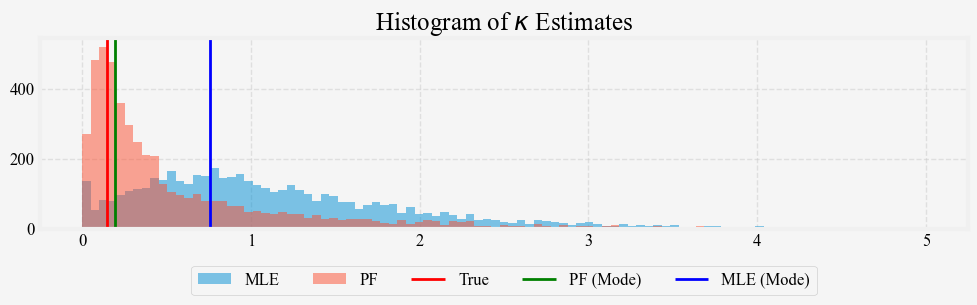

In [271]:
peak_kappa_pf = kappa_particles_mode(kappa_ests)
peak_kappa_mle = kappa_particles_mode(kappa_ests_mle)
bins = np.linspace(0, 5, 100)
plt.hist(kappa_ests_mle, bins=bins, alpha=0.5, label='MLE')
plt.hist(kappa_ests, bins=bins, alpha=0.5, label='PF')
plt.axvline(kappa, color='r', label='True')
plt.axvline(peak_kappa_pf, color='g', label='PF (Mode)')
plt.axvline(peak_kappa_mle, color='b', label='MLE (Mode)')
plt.legend(loc='upper center', 
           bbor_to_anchor=(0.5, -0.15), 
           ncol=5)
plt.title('Histogram of $\kappa$ Estimates')
# Adjust the bottom margin to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
kappa, peak_kappa_pf, peak_kappa_mle

## Vasicek Model Bond Price and Yield

In [191]:
def B(t, T, kappa, theta, sigma):
    tau = T - t
    return (1 - np.exp(-kappa * tau)) / kappa

def A(t, T, kappa, theta, sigma):
    tau = T - t
    return np.exp((theta - (sigma**2) / (2 * kappa**2)) * (B(t, T, kappa, theta, sigma) - tau) - (sigma**2) * (B(t, T, kappa, theta, sigma)**2) / (4 * kappa))

def zero_coupon_bond_price(t, T, r, kappa, theta, sigma):
    return A(t, T, kappa, theta, sigma) * np.exp(-B(t, T, kappa, theta, sigma) * r)

def zero_coupon_yield(t, T, r, kappa, theta, sigma):
    price = zero_coupon_bond_price(t, T, r, kappa, theta, sigma)
    return -np.log(price) / (T - t)

In [192]:

# Example usage
r = 0.05  # Current short rate
kappa = 0.1
theta = 0.05
sigma = 0.02
T = 1.0  # Maturity time in years

# Compute the zero-coupon bond price
price = zero_coupon_bond_price(0, T, r, kappa, theta, sigma)
print(f"Zero-coupon bond price: {price}")


Zero-coupon bond price: 0.9512882997253278


In [209]:
r, kappa, theta, sigma = 0.03, 0.15, 0.05, 0.01
rates = simulate_vasicek_short_rates_exact(r, kappa, theta, sigma, t, dt, 42)
yield_05 = np.asarray([zero_coupon_yield(0,  5, r, kappa, theta, sigma) for r in rates[1]])
yield_10 = np.asarray([zero_coupon_yield(0, 10, r, kappa, theta, sigma) for r in rates[1]])
yield_30 = np.asarray([zero_coupon_yield(0, 30, r, kappa, theta, sigma) for r in rates[1]])

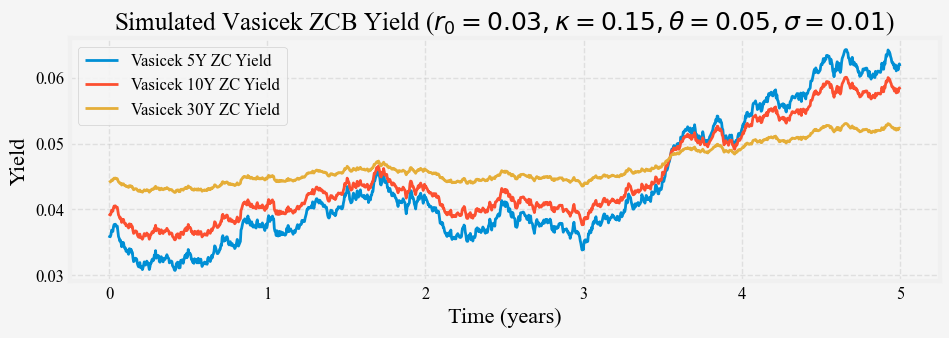

<Figure size 1000x300 with 0 Axes>

In [212]:
plt.plot(rates[0], yield_05, label='Vasicek 5Y ZC Yield')
plt.plot(rates[0], yield_10, label='Vasicek 10Y ZC Yield')
plt.plot(rates[0], yield_30, label='Vasicek 30Y ZC Yield')

plt.title('Simulated Vasicek ZCB Yield ($r_0=0.03, \kappa=0.15, \\theta=0.05, \sigma=0.01 $)')
plt.xlabel('Time (years)')
plt.ylabel('Yield')
plt.legend()
plt.show()
plt.tight_layout();

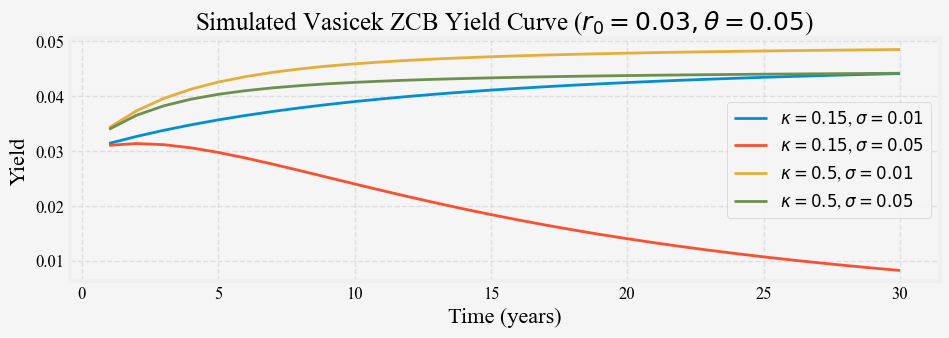

<Figure size 1000x300 with 0 Axes>

In [215]:
tenors = np.arange(1, 31)
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.03, 0.15, 0.05, 0.01), label="$\kappa=0.15$, $\sigma=0.01$")
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.03, 0.15, 0.05, 0.05), label="$\kappa=0.15$, $\sigma=0.05$")
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.03, 0.5, 0.05, 0.01), label="$\kappa=0.5$, $\sigma=0.01$")
plt.plot(tenors, zero_coupon_yield(0, tenors, 0.03, 0.5, 0.05, 0.05), label="$\kappa=0.5$, $\sigma=0.05$")


plt.title('Simulated Vasicek ZCB Yield Curve ($r_0=0.03, \\theta=0.05$)')
plt.xlabel('Time (years)')
plt.ylabel('Yield')
plt.legend()
plt.show()
plt.tight_layout();